In [53]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'log', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [36]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

import tensorflow as tf
import numpy as np
import os
import fnmatch
import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn import manifold, datasets
from sklearn import feature_selection

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from time import time

import seaborn as sns

COMET WARNING: We detected that you are running inside a Ipython/Jupyter notebook environment but we cannot save your notebook source code. Please be sure to have installed comet_ml as a notebook server extension by running:
jupyter comet_ml enable
COMET INFO: old comet version (1.0.9) detected. current: 1.0.13 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Comet.ml support for Ipython Notebook is limited at the moment, automatic monitoring and stdout capturing is deactivated
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/incnas/general/6816a90e455a4ba2b88934b99d10bbf3



In [3]:
from shutil import copyfile
import scipy.misc

In [4]:
sns.set(style="white")

## Load Data

In [5]:
path = "data\\sorted\\agg\\ids.csv"
root_dir = "data\\sorted\\agg\\"

In [6]:
data = pd.read_csv(path, index_col=0)

In [7]:
data = data.sample(frac=1)

In [8]:
data.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks
354,56_flipped,2017.11.17,7200,16.65 s.tifheightmap.mat,1.287939,7944,4310.812381,0.855164,1,0.251953,0.514171,[[8.38400000e+03 1.15510600e+06 2.05890328e+08...,1.525279,1095.470129,[[1508.84702727 185.61915263]\r\n [ 185.61915...,1,2
179,179,2017.11.23,3600,65.00 s.tifheightmap.mat,9.817343,1582,8839.578970,0.824524,1,0.558025,5.587597,[[1.58200000e+03 4.02930000e+04 1.43790700e+06...,1.375286,183.338095,[[ 92.35607922 34.59954753]\r\n [ 34.59954753...,0,1
372,72_flipped,2017.11.17,7200,5.20 s.tifheightmap.mat,6.577711,7998,12404.227215,0.999753,1,0.537934,1.549560,[[8.00500000e+03 2.60840000e+06 1.17772984e+09...,1.569433,1380.818326,[[2.02879511e+01 5.57794988e+01]\r\n [5.577949...,1,1
232,126_flipped,2017.11.22,7200,71.80 s.tifheightmap.mat,6.576827,2467,10358.064751,0.825753,1,0.719032,4.198648,[[2.46700000e+03 8.50100000e+04 3.79811000e+06...,1.395755,203.195959,[[121.83336195 42.04748255]\r\n [ 42.04748255...,0,1
157,157,2017.11.23,3600,10.60 s.tifheightmap.mat,9.043373,1740,7173.507255,0.858150,1,0.434959,3.943654,[[1.81900000e+03 4.83140000e+04 2.00868200e+06...,-1.163312,238.267027,[[ 171.02166098 -120.83480191]\r\n [-120.83480...,2,1


In [9]:
samples = data.drop(columns=['name','date','source','moments','orientation','inertia_tensor'])
train_data = samples.drop(columns=['flow_rate'])

In [10]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 354 to 112
Data columns (total 11 columns):
flow_rate         402 non-null int64
peak_val          402 non-null float64
area              402 non-null int64
volume            402 non-null float64
eccentricity      402 non-null float64
euler_number      402 non-null int64
extent            402 non-null float64
mean_intensity    402 non-null float64
perimeter         402 non-null float64
cluster           402 non-null int64
num_peaks         402 non-null int64
dtypes: float64(6), int64(5)
memory usage: 37.7 KB


In [11]:
points = train_data.as_matrix()
normalized = preprocessing.Normalizer().fit_transform(points)
standardize = preprocessing.scale(points)

df_standardize = preprocessing.scale(samples.as_matrix())

In [12]:
normalized.shape

(402, 10)

## Data Anaylysis

## K-Means

Source: https://www.tensorflow.org/api_docs/python/tf/contrib/factorization/KMeansClustering

In [13]:
def input_fn():
    return tf.train.limit_epochs(tf.convert_to_tensor(standardize, dtype=tf.float32), num_epochs=1)

In [14]:
num_clusters = 3
kmeans = tf.contrib.factorization.KMeansClustering(num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 30
previous_centers = None

# Report hyper params:
hyper_params = {"clusters": num_clusters, "iterations": num_iterations}
experiment.log_multiple_params(hyper_params)

for _ in range(num_iterations):
    kmeans.train(input_fn)
    cluster_centers = kmeans.cluster_centers()
    if previous_centers is not None:
        print('delta:', cluster_centers - previous_centers)
    previous_centers = cluster_centers
    experiment.log_metric("score", kmeans.score(input_fn))
    print('score:', kmeans.score(input_fn))
print('cluster centers:', cluster_centers)

# map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(points):
    cluster_index = cluster_indices[i]
    center = cluster_centers[cluster_index]
    print('point:', point, 'is in cluster', cluster_index, 'centered at', center)

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Duo\\AppData\\Local\\Temp\\tmpfzo2emdj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002D20352E320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Savi

INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-7
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-17-07:56:28
INFO:tensorflow:Saving dict for global step 7: global_step = 7, loss = 2569.1604, score = 2569.1604
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-07:56:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-7
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-17-07:56:29
INFO:tensorflow:Saving dict for global step 7: global_step = 7, loss = 2569.1604, score = 2569.1604
score: 2569.1604
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mod

INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-17-07:56:34
INFO:tensorflow:Saving dict for global step 15: global_step = 15, loss = 2562.1184, score = 2562.1184
score: 2562.1184
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 16 into C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt.
INFO:tensorflow:loss = 2562.1184, step = 15
INFO:tensorflow:Saving checkpoints for 17 into C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt.
INFO:tensorflow:Los

INFO:tensorflow:loss = 2562.1184, step = 23
INFO:tensorflow:Saving checkpoints for 25 into C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt.
INFO:tensorflow:Loss for final step: 2562.1184.
delta: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-07:56:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-25
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-17-07:56:40
INFO:tensorflow:Saving dict for global step 25: global_step = 25, loss = 2562.1184, score = 2562.1184
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-07:56:41
INFO:tensorflow:Grap

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-07:56:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-33
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-17-07:56:46
INFO:tensorflow:Saving dict for global step 33: global_step = 33, loss = 2562.1184, score = 2562.1184
score: 2562.1184
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-33
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 34 into C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckp

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 42 into C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt.
INFO:tensorflow:loss = 2562.1184, step = 41
INFO:tensorflow:Saving checkpoints for 43 into C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt.
INFO:tensorflow:Loss for final step: 2562.1184.
delta: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-07:56:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-43
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-17-07:56:53
INFO:tensorflow:Saving dict for global step 43: global_step = 43, lo

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-17-07:56:58
INFO:tensorflow:Saving dict for global step 51: global_step = 51, loss = 2562.1184, score = 2562.1184
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-07:56:58
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-51
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-17-07:56:58
INFO:tensorflow:Saving dict for global step 51: global_step = 51, loss = 2562.1184, score = 2562.1184
score: 2562.1184
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmpfzo2emdj\model.ckpt-59
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
point: [1.28793902e+00 7.94400000e+03 4.31081238e+03 8.55164365e-01
 1.00000000e+00 2.51953360e-01 5.14171324e-01 1.09547013e+03
 1.00000000e+00 2.00000000e+00] is in cluster 2 centered at [-0.6550436  -0.3114864  -0.4127071   0.14671724  0.15751474 -0.17779465
 -0.653379   -0.14436816  1.1100065  -0.02238228]
point: [9.81734264e+00 1.58200000e+03 8.83957897e+03 8.24523660e-01
 1.00000000e+00 5.58024691e-01 5.58759733e+00 1.83338095e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [6.57771138e+00 7.99800000e+03 1.24042272e+04 9.99753173e-01
 1.00000000e+00

  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [1.59638225e+01 2.73700000e+03 1.91197123e+04 9.63145483e-01
 1.00000000e+00 6.26889601e-01 6.98564572e+00 2.99480231e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [6.17118412e+00 1.89900000e+03 5.82507883e+03 8.39398031e-01
 1.00000000e+00 5.41831543e-01 3.03864311e+00 2.39379726e+02
 2.00000000e+00 1.00000000e+00] is in cluster 2 centered at [-0.6550436  -0.3114864  -0.4127071   0.14671724  0.15751474 -0.17779465
 -0.653379   -0.14436816  1.1100065  -0.02238228]
point: [1.20882046e+01 1.55200000e+03 1.10768345e+04 8.33426062e-01
 1.00000000e+00 7.26932084e-01 7.13713565e+00 1.61053824e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [2.3741

  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [8.15311636e+00 6.01800000e+03 2.37493138e+04 9.78475879e-01
 1.00000000e+00 5.82067898e-01 3.94637982e+00 5.51203102e+02
 2.00000000e+00 1.00000000e+00] is in cluster 2 centered at [-0.6550436  -0.3114864  -0.4127071   0.14671724  0.15751474 -0.17779465
 -0.653379   -0.14436816  1.1100065  -0.02238228]
point: [5.07063370e+00 4.67600000e+03 1.18306380e+04 9.74598425e-01
 1.00000000e+00 4.28205128e-01 2.53007657e+00 4.55847763e+02
 2.00000000e+00 1.00000000e+00] is in cluster 2 centered at [-0.6550436  -0.3114864  -0.4127071   0.14671724  0.15751474 -0.17779465
 -0.653379   -0.14436816  1.1100065  -0.02238228]
point: [9.28266138e+00 2.27600000e+03 1.21502839e+04 9.87456421e-01
 1.00000000e+00 6.92214112e-01 5.33843755e+00 3.04367532e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [8.1742

 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [7.46167773e+00 5.39000000e+03 1.56942184e+04 9.25198525e-01
 1.00000000e+00 4.27538462e-01 2.82371688e+00 5.57847763e+02
 2.00000000e+00 1.00000000e+00] is in cluster 2 centered at [-0.6550436  -0.3114864  -0.4127071   0.14671724  0.15751474 -0.17779465
 -0.653379   -0.14436816  1.1100065  -0.02238228]
point: [1.25322336e+01 4.75600000e+03 3.80340385e+04 7.56339059e-01
 1.00000000e+00 7.17995169e-01 7.99706444e+00 2.92693434e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [6.68369305e+00 2.11800000e+03 8.88232793e+03 9.16710933e-01
 1.00000000e+00 5.42381562e-01 4.19373368e+00 2.01137085e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.

 2.00000000e+00 1.00000000e+00] is in cluster 2 centered at [-0.6550436  -0.3114864  -0.4127071   0.14671724  0.15751474 -0.17779465
 -0.653379   -0.14436816  1.1100065  -0.02238228]
point: [1.13897033e+01 8.36400000e+03 3.41389550e+04 6.78217184e-01
 1.00000000e+00 5.51787835e-01 4.08165411e+00 5.04658946e+02
 2.00000000e+00 1.00000000e+00] is in cluster 2 centered at [-0.6550436  -0.3114864  -0.4127071   0.14671724  0.15751474 -0.17779465
 -0.653379   -0.14436816  1.1100065  -0.02238228]
point: [7.74862675e+00 5.27800000e+03 2.13186378e+04 8.29301352e-01
 1.00000000e+00 5.01234568e-01 4.03915078e+00 4.01161472e+02
 2.00000000e+00 1.00000000e+00] is in cluster 2 centered at [-0.6550436  -0.3114864  -0.4127071   0.14671724  0.15751474 -0.17779465
 -0.653379   -0.14436816  1.1100065  -0.02238228]
point: [1.00522540e+01 5.02500000e+03 2.05211966e+04 8.75886346e-01
 1.00000000e+00 3.75224014e-01 4.08382021e+00 4.50274170e+02
 2.00000000e+00 1.00000000e+00] is in cluster 2 centered at [-0.

  1.2157911   1.9929967  -0.5466133   1.3263249 ]
point: [9.93031909e+00 2.32600000e+03 1.54174588e+04 4.03827232e-01
 1.00000000e+00 7.69179894e-01 6.62831419e+00 1.91396970e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [6.91784295e+00 3.96500000e+03 1.70664212e+04 6.62411117e-01
 1.00000000e+00 6.95126227e-01 4.30426765e+00 2.64693434e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [9.21858955e+00 1.55200000e+03 7.42646629e+03 6.14255972e-01
 1.00000000e+00 7.14219972e-01 4.78509426e+00 1.62568542e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [1.6556

 -0.653379   -0.14436816  1.1100065  -0.02238228]
point: [1.82868504e+01 2.62400000e+03 2.34183288e+04 8.39932320e-01
 1.00000000e+00 7.14013605e-01 8.92466798e+00 2.07923882e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]
point: [1.40881936e+01 3.14500000e+03 2.59692361e+04 8.80974449e-01
 1.00000000e+00 5.03925653e-01 8.25730878e+00 2.69906638e+02
 0.00000000e+00 1.00000000e+00] is in cluster 1 centered at [ 0.34729433 -0.12301097 -0.03676078 -0.21828106  0.16991022  0.34665626
  0.33332944 -0.23986888 -0.8424378  -0.2221592 ]


### Save Result

In [15]:
data['cluster'] = cluster_indices
#data.to_csv(path)

In [16]:
for i in range(num_clusters):
    directory = os.path.join(root_dir, str(i)+"_"+str(num_clusters))

    if not os.path.exists(directory):
        os.makedirs(directory)

In [17]:
for index, row in data.iterrows():
    name = row['name']
    cluster = row['cluster']
    
    copyfile(f'{root_dir}{name}.npy', f'{root_dir}{cluster}_{num_clusters}\\{name}.npy')
    
    image_array = np.load(f'{root_dir}{cluster}_{num_clusters}\\{name}.npy')
    scipy.misc.imsave(f'{root_dir}{cluster}_{num_clusters}\\{name}.jpg', image_array)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


## Visualisations:

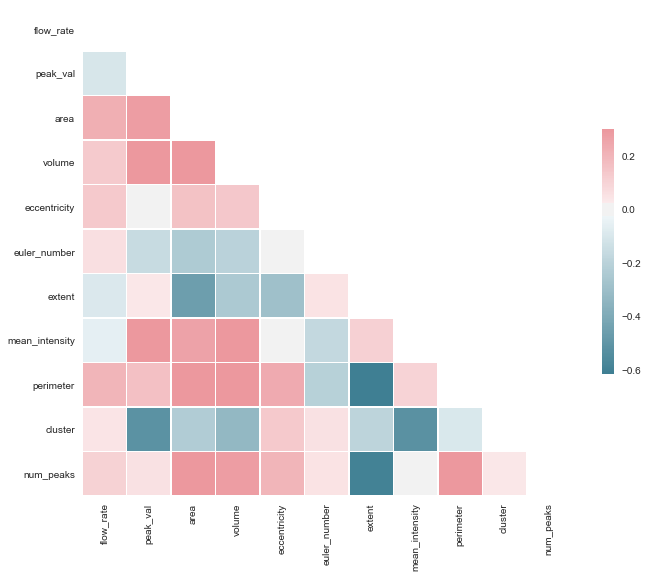

In [18]:
# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 #columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = pd.DataFrame(data=df_standardize,columns=list(samples)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

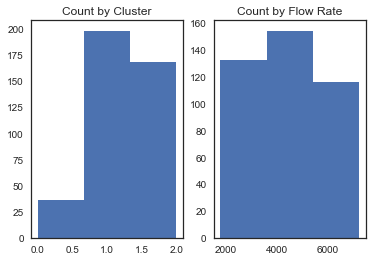

In [19]:
t = data[data['flow_rate']==1800]
u = data[data['flow_rate']==3600]
v = data[data['flow_rate']==7200]

a = data[data['cluster']==0]
b = data[data['cluster']==1]
c = data[data['cluster']==2]

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Peaks by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')

plt.subplot(121)
plt.title("Num Peaks by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')'''

plt.subplot(121)
plt.title("Count by Cluster")
plt.hist(data['cluster'], bins=3)

plt.subplot(122)
plt.title("Count by Flow Rate")
plt.hist(data['flow_rate'], bins=3)

plt.show()

Number of different blobs as identified by Otsu's

Num Peaks by Flow Rate: 
1800: [118, 14, 0]
3600: [132, 18, 4]
7200: [94, 18, 4]


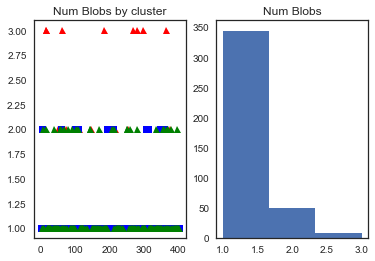

In [20]:
t = data[data['cluster']==0]['num_peaks']
u = data[data['cluster']==1]['num_peaks']
v = data[data['cluster']==2]['num_peaks']

N = 3

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

a = data[data['flow_rate']==1800]
a = a.groupby('num_peaks').size().tolist()
a.append(0)

b = data[data['flow_rate']==3600]
b = b.groupby('num_peaks').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('num_peaks').size().tolist()

print("Num Peaks by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Blobs by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')'''

plt.subplot(121)
plt.title("Num Blobs by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.subplot(122)
plt.title("Num Blobs")
plt.hist(data['num_peaks'], bins=3)

plt.show()

Peak Value of each image

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


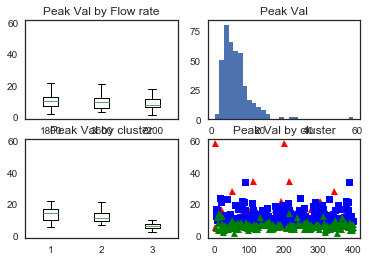

In [21]:
t = data[data['cluster']==0]['peak_val']
u = data[data['cluster']==1]['peak_val']
v = data[data['cluster']==2]['peak_val']

a = data[data['flow_rate']==1800]['peak_val']
b = data[data['flow_rate']==3600]['peak_val']
c = data[data['flow_rate']==7200]['peak_val']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Peak Val by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Peak Val")
plt.hist(data['peak_val'], bins=30)

plt.subplot(223)
plt.title("Peak Val by cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Peak Val by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


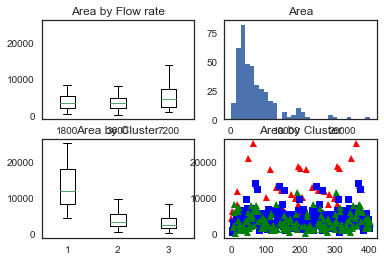

In [22]:
t = data[data['cluster']==0]['area']
u = data[data['cluster']==1]['area']
v = data[data['cluster']==2]['area']

a = data[data['flow_rate']==1800]['area']
b = data[data['flow_rate']==3600]['area']
c = data[data['flow_rate']==7200]['area']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Area by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Area")
plt.hist(data['area'], bins=30)

plt.subplot(223)
plt.title("Area by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Area by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


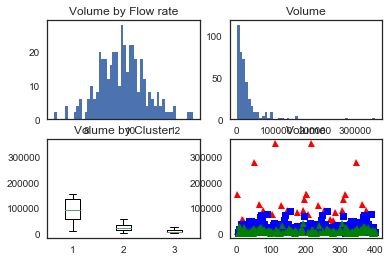

In [23]:
t = data[data['cluster']==0]['volume']
u = data[data['cluster']==1]['volume']
v = data[data['cluster']==2]['volume']

a = data[data['flow_rate']==1800]['volume']
b = data[data['flow_rate']==3600]['volume']
c = data[data['flow_rate']==7200]['volume']

log = data['volume'].apply(np.log)

plt.subplot(221)
plt.title("Volume by Flow rate")
#plt.boxplot([a,b,c], labels=['1800','3600','7200'])
plt.hist(log, bins=50)

plt.subplot(222)
plt.title("Volume")
plt.hist(data['volume'], bins=50)

plt.subplot(223)
plt.title("Volume by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Volume")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


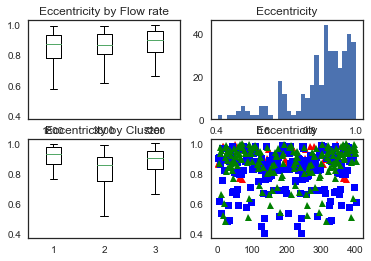

In [24]:
t = data[data['cluster']==0]['eccentricity']
u = data[data['cluster']==1]['eccentricity']
v = data[data['cluster']==2]['eccentricity']

a = data[data['flow_rate']==1800]['eccentricity']
b = data[data['flow_rate']==3600]['eccentricity']
c = data[data['flow_rate']==7200]['eccentricity']

plt.subplot(221)
plt.title("Eccentricity by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Eccentricity")
plt.hist(data['eccentricity'], bins=30)

plt.subplot(223)
plt.title("Eccentricity by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Eccentricity")
plt.plot(t, 'r^', u, 'bs', v, 'g^')


plt.show()

Euler characteristic of region. Computed as number of objects (= 1) subtracted by number of holes (8-connectivity).

Euler Number by Flow Rate: 
1800: [4, 6, 122]
3600: [8, 146]
7200: [6, 110]


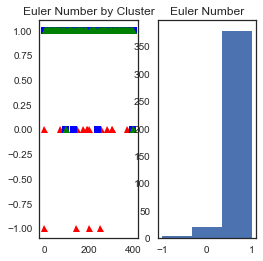

In [25]:
t = data[data['cluster']==0]['euler_number']
u = data[data['cluster']==1]['euler_number']
v = data[data['cluster']==2]['euler_number']

a = data[data['flow_rate']==1800]
a = a.groupby('euler_number').size().tolist()

b = data[data['flow_rate']==3600]
b = b.groupby('euler_number').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('euler_number').size().tolist()

print("Euler Number by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''plt.subplot(131)
plt.title("Euler Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])'''

plt.subplot(132)
plt.title("Euler Number by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.subplot(133)
plt.title("Euler Number")
plt.hist(data['euler_number'], bins=3)

plt.show()

Ratio of pixels in the region to pixels in the total bounding box. Computed as area / (rows * cols)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


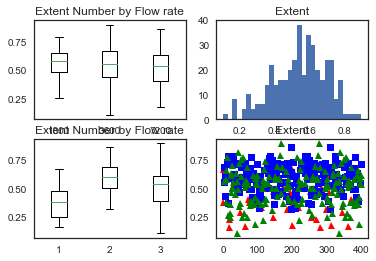

In [26]:
t = data[data['cluster']==0]['extent']
u = data[data['cluster']==1]['extent']
v = data[data['cluster']==2]['extent']

a = data[data['flow_rate']==1800]['extent']
b = data[data['flow_rate']==3600]['extent']
c = data[data['flow_rate']==7200]['extent']

plt.subplot(221)
plt.title("Extent Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Extent")
plt.hist(data['extent'], bins=30)

plt.subplot(223)
plt.title("Extent Number by Flow rate")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Extent")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


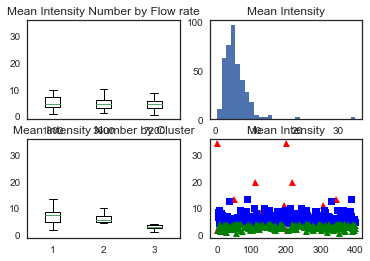

In [27]:
t = data[data['cluster']==0]['mean_intensity']
u = data[data['cluster']==1]['mean_intensity']
v = data[data['cluster']==2]['mean_intensity']

a = data[data['flow_rate']==1800]['mean_intensity']
b = data[data['flow_rate']==3600]['mean_intensity']
c = data[data['flow_rate']==7200]['mean_intensity']

plt.subplot(221)
plt.title("Mean Intensity Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Mean Intensity")
plt.hist(data['mean_intensity'], bins=30)

plt.subplot(223)
plt.title("Mean Intensity Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Mean Intensity")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

Angle between the X-axis and the major axis of the ellipse that has the same second-moments as the region. Ranging from -pi/2 to pi/2 in counter-clockwise direction.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


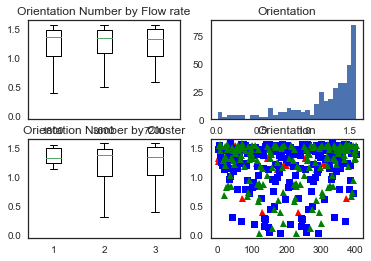

In [28]:
t = pd.DataFrame.abs(data[data['cluster']==0]['orientation'])
u = pd.DataFrame.abs(data[data['cluster']==1]['orientation'])
v = pd.DataFrame.abs(data[data['cluster']==2]['orientation'])

a = pd.DataFrame.abs(data[data['flow_rate']==1800]['orientation'])
b = pd.DataFrame.abs(data[data['flow_rate']==3600]['orientation'])
c = pd.DataFrame.abs(data[data['flow_rate']==7200]['orientation'])

plt.subplot(221)
plt.title("Orientation Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Orientation")
plt.hist(pd.DataFrame.abs(data['orientation']), bins=30)

plt.subplot(223)
plt.title("Orientation Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Orientation")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


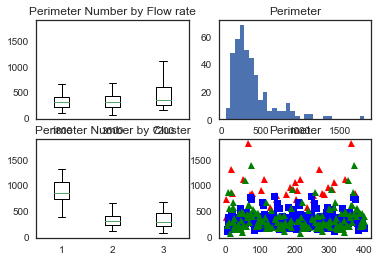

In [29]:
t = data[data['cluster']==0]['perimeter']
u = data[data['cluster']==1]['perimeter']
v = data[data['cluster']==2]['perimeter']

a = data[data['flow_rate']==1800]['perimeter']
b = data[data['flow_rate']==3600]['perimeter']
c = data[data['flow_rate']==7200]['perimeter']

plt.subplot(221)
plt.title("Perimeter Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Perimeter")
plt.hist(data['perimeter'], bins=30)

plt.subplot(223)
plt.title("Perimeter Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Perimeter")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

In [30]:
#moments = data['moments'].as_matrix()
#print(moments)

for row in data['inertia_tensor']:
    print(row)
    #moments.append()

[[1508.84702727  185.61915263]
 [ 185.61915263 5575.56580868]]
[[ 92.35607922  34.59954753]
 [ 34.59954753 260.21368117]]
[[2.02879511e+01 5.57794988e+01]
 [5.57794988e+01 4.09484361e+04]]
[[121.83336195  42.04748255]
 [ 42.04748255 352.1534552 ]]
[[ 171.02166098 -120.83480191]
 [-120.83480191  398.80485837]]
[[240.65831223 116.2303076 ]
 [116.2303076  460.64671862]]
[[158.53893632 147.33011794]
 [147.33011794 227.97205235]]
[[203.14008428 -84.6848343 ]
 [-84.6848343  586.61444053]]
[[ 67.23740305  12.97797057]
 [ 12.97797057 474.12266486]]
[[1.23203633e+02 2.71778206e-01]
 [2.71778206e-01 3.18389682e+02]]
[[134.86353137 -16.81068132]
 [-16.81068132 602.20527464]]
[[ 828.87748151  615.47622163]
 [ 615.47622163 1833.99961943]]
[[ 95.96786714   7.6775466 ]
 [  7.6775466  121.26309767]]
[[ 44.53901756 -20.42403231]
 [-20.42403231 211.33180343]]
[[1993.99030592  -44.18331113]
 [ -44.18331113  421.95972679]]
[[ 480.1139295  -337.80767374]
 [-337.80767374 1341.13579308]]
[[ 158.53893632 -147

### Cluster sizes

In [31]:
print(len(data[data['cluster']==0]))
print(len(data[data['cluster']==1]))
print(len(data[data['cluster']==2]))

36
198
168


### Comparison of Manifold Algorithms

Source: http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

standard: 0.33 sec
ltsa: 0.19 sec
hessian: 0.26 sec
modified: 0.25 sec
Isomap: 0.23 sec
MDS: 0.6 sec
SpectralEmbedding: 0.029 sec
t-SNE: 38 sec


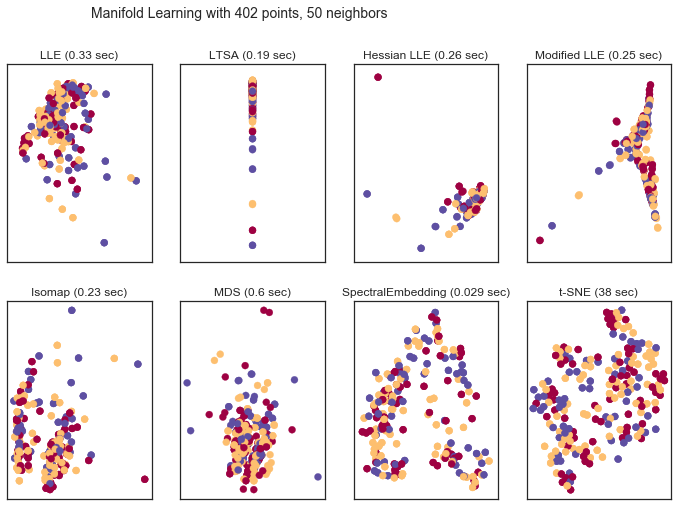

In [32]:
n_neighbors = 50
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (len(points), n_neighbors), fontsize=14)

X = standardize
color = data['flow_rate']

''' ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72) '''

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca',n_iter=5000, random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

0
t-SNE: 1.7e+02 sec
1
t-SNE: 1.6e+02 sec
2
t-SNE: 2.1e+02 sec
3
t-SNE: 2.2e+02 sec
4
t-SNE: 69 sec


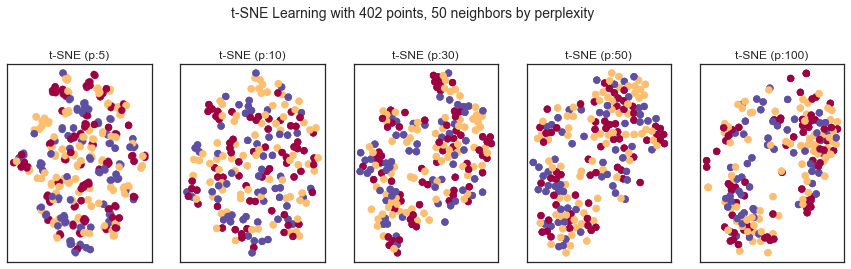

In [35]:
perplexity = [5,10,30,50,100]

fig = plt.figure(figsize=(15, 8))
plt.suptitle("t-SNE Learning with %i points, %i neighbors by perplexity"
             % (len(points), n_neighbors), fontsize=14)

for i,p in enumerate(perplexity):
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, perplexity=p, init='pca',n_iter=5000, random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(251+i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("t-SNE (p:%d)" % (p))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

plt.show()

## Mutual Information

In [49]:
print(feature_selection.mutual_info_classif(samples.as_matrix(), data['flow_rate']))
print(list(train_data.head()))

[1.09437415 0.33133396 0.3751952  0.36516039 0.38596521 0.
 0.34448513 0.3552698  0.36229726 0.         0.04599177]
['peak_val', 'area', 'volume', 'eccentricity', 'euler_number', 'extent', 'mean_intensity', 'perimeter', 'cluster', 'num_peaks']


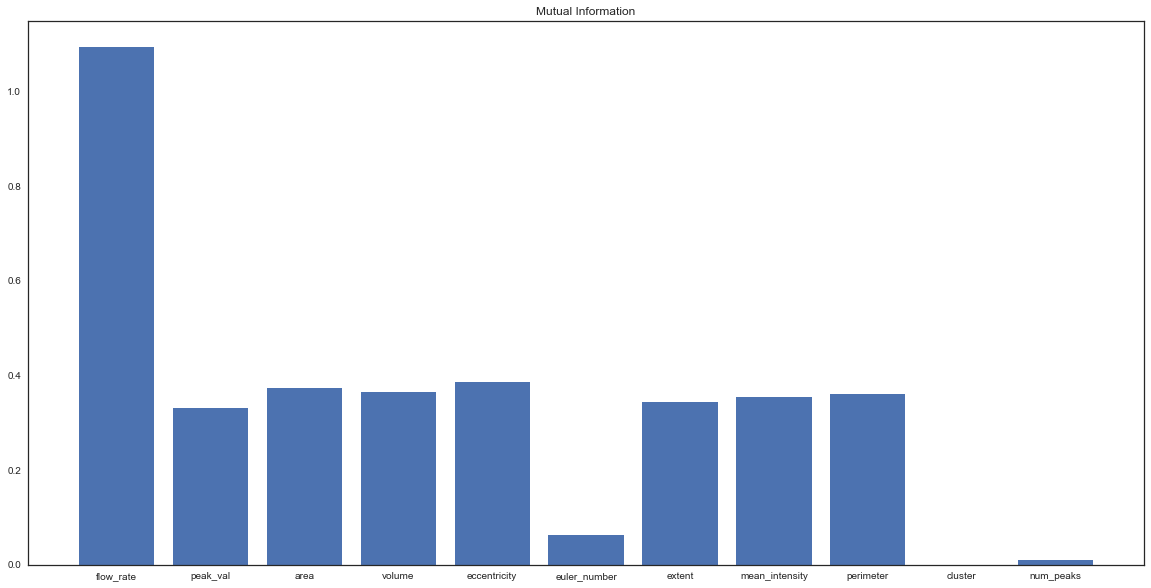

In [55]:
mi = feature_selection.mutual_info_classif(samples.as_matrix(), data['flow_rate'])
labels = list(samples.head())

x = np.arange(len(mi))

fig, ax = plt.subplots()
plt.title("Mutual Information")
plt.bar(x, mi)
plt.xticks(x, labels)

plt.show()